# Code for The Neural Network Part of our Final Project

## ITU Machine Learning Fall 2021

### Group AC
Chrisanna Cornish <ccor@itu.dk> <br>
Carl August Wismer <cwis@itu.dk><br>
Danielle Marie Dequin <ddeq@itu.dk>

Last Edited: 27/12/2021

## Imports

In [1]:
import numpy as np
import pandas as pd
import random as rn

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
import warnings

from sklearn.metrics import *

from tensorflow.keras import backend as K
from tensorflow.keras import metrics, regularizers, optimizers
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Model
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_addons as tfa

from sklearn.model_selection import KFold

#import scipy as sp
#from sklearn.datasets import make_classification

warnings.filterwarnings("ignore")

## Paths

In [2]:
TRAIN = '../Data/df_train.csv'
TEST = '../Data/df_test.csv'

## Functions

In [3]:
z_score = lambda x : (x-np.mean(x,axis=0))/ np.std(x,axis=0) # code from exercise 5

In [9]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    Function copied from exercise 7.
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.ylim([-0.5, cm.shape[0]-0.5])

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [10]:
def stats_class(x = None, y = None, label = 'Training', modl = None):
    """Function to print the classification report, including the precision, recall,
    f1 score, and support. Copied from Exercise 7.
    input :  
             x = input
             y = output
             label = "Provided text string"
             modl = the model
             
    output : 
             sklearn.metrics.classification_report
    """

    y_prediction = modl.predict(x, verbose=0)
    y_prd = (y_prediction> 0.5).astype(int) 
    
    print('\n','#'*10,'STATISTICS for {} Data'.format(label), '#'*10, '\n')
    print(classification_report(y, y_prd))
    print('\n','#'*50)
    return 
                

def stats_reg(d = None, d_pred = None, label = 'Training', estimat = None):
    """Function copied from exercise 7.
    """
    A = ['MSE', 'CorrCoeff']
    
    pcorr = np.corrcoef(d, d_pred)[1,0]
    
    if label.lower() in ['training', 'trn', 'train']:
        mse = estimat.history['loss'][-1]
    else:
        mse = estimat.history['val_loss'][-1] 

    B = [mse, pcorr]
    
    print('\n','#'*10,'STATISTICS for {} Data'.format(label), '#'*10, '\n')
    for r in zip(A,B):
         print(*r, sep = '   ')
    print('\n','#'*50)
    return 

## Variables and df loading

In [4]:
col = 'tab10' # colour theme

df = pd.read_csv(TRAIN) # Training dataframe

attributes = list(df.columns)[:-1] # List of column names for the dataframe

X = df[attributes].copy() # attributes
y = df['type'].copy() # true values

y_types = {1:'wind_float', 2:'wind_non', 3:'wind_veh', 5:'container', 6:'tableware', 7:'headlamp'}
y_list = y.unique() #'y' values

X_std = z_score(X) # Standardizes X as later we see they are on different scales

for i in y_list: # Change the 'type' to a descriptive word rather than a number
    # This is more human readable for plotting later - 'y' is still using the numbers
    df['type'][df['type'] == i] = y_types[i]

## Change X to numpy array

In [ ]:
X_std_np = X_std.to_numpy()

## Shift y values

In [5]:
y2 = y.copy()

In [6]:
for i in range(len(y2)):
    if y2[i] > 4:
        y2[i] = y2[i] - 2
    else:
        y2[i] = y2[i] - 1

In [55]:
y2.unique(), y2.shape

(array([1, 0, 3, 5, 4, 2], dtype=int64), (149,))

## One-Hot Encoding for labels

In [45]:
one_hot_y = np.zeros((X_std_np.shape[0], len(y2.unique()))) # one hot labels
for i in range(X_std_np.shape[0]):
    one_hot_y[i, y2[i]] = 1
one_hot_y.shape

(149, 6)

# NN Using Pre-made Libraries

In [11]:
# Metric options
# [tf.keras.metrics.Precision()] to use precision
# ['accuracy'] to use accuracy

In [29]:
def pipeline_(inp_dim, # input dimension (an int)
            n_nod, # network size [5] for one layer of 5 nodes, [5,3] for 2 layers with 5 and 3 nodes
            drop_nod = None,
            act_fun = 'tanh',
            out_act_fun = 'sigmoid',
            opt_method = 'SGD',
            cost_fun = 'binary_crossentropy',
            lr_rate = 0.01,
            lambd = 0.0, 
            num_out = 6): # the number of output nodes
            
    main_input = Input(shape=(inp_dim,), dtype='float32', name='main_input') # inputs used to build the model
    
    X = main_input
    for i, nod in enumerate(n_nod):
        X = Dense(nod, # make a dense layer of nod nodes
                  activation = act_fun,
                  kernel_regularizer=regularizers.l2(lambd))(X) ############ why put the main_input at the end here?
        if drop_nod is not None: # nodes to drop out (when training)
            X = Dropout(drop_nod[i])(X)
    output = Dense(num_out, activation = out_act_fun )(X)
    
    method = getattr(optimizers, opt_method) # get the attributes from the specified optimizer
    
    model =  Model(inputs=[main_input], outputs=[output]) # bulid a model with specified input and outputs
    model.compile(optimizer = method(learning_rate = lr_rate, clipnorm = 1.0),
                  loss = cost_fun,
                  metrics=[tfa.metrics.F1Score(6, 'macro')])   
    
    return model

In [46]:
y2.shape, X_std_np.shape

((149,), (149, 9))

In [83]:
# seed = 0 means random, seed > 0 means fixed
seed = 42
np.random.seed(seed) if seed else None

# Define the network, cost function and minimization method
INPUT = {'inp_dim': X_std_np.shape[1],         
         'n_nod': [10],                     # number of nodes in hidden layer (one layer, one node)
         'act_fun': 'tanh',                 # activation functions for the hidden layer
         'out_act_fun': 'softmax',          # output activation function, using sigmoid for binary classification
         'opt_method': 'SGD',               # minimization method
         'cost_fun': 'categorical_crossentropy', # error/cost function
         'lr_rate': 0.1,                    # learningrate
         'num_out' : 6 }              # if binary --> 1 |  regression--> num inputs | multi-class--> num of classes

# Get the model
model = pipeline_(**INPUT)

# Print a summary of the model
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 9)]               0         
_________________________________________________________________
dense_14 (Dense)             (None, 10)                100       
_________________________________________________________________
dense_15 (Dense)             (None, 6)                 66        
Total params: 166
Trainable params: 166
Non-trainable params: 0
_________________________________________________________________


In [84]:
# Train the model
estimator_ex1 = model.fit(X_std_np, one_hot_y,
                      epochs = 500,                     # Number of epochs (iterations through the whole dataset, right######)
                      #validation_data=(x_val, y_val),  # We don't have any validation dataset!
                      #batch_size = X_std.shape[0],     # Use batch learning
                      #batch_size=25,                   # number of samples processed before the model is updated
                      verbose = 0)


 ########## Result for Test Data ########## 

log_loss:    0.2684931020512583
accuracy:    0.8993288590604027 

              precision    recall  f1-score   support

     class 1       0.85      0.90      0.87        49
     class 2       0.88      0.87      0.88        53
     class 3       0.90      0.75      0.82        12
     class 4       1.00      1.00      1.00         9
     class 5       1.00      1.00      1.00         6
     class 6       1.00      1.00      1.00        20

    accuracy                           0.90       149
   macro avg       0.94      0.92      0.93       149
weighted avg       0.90      0.90      0.90       149



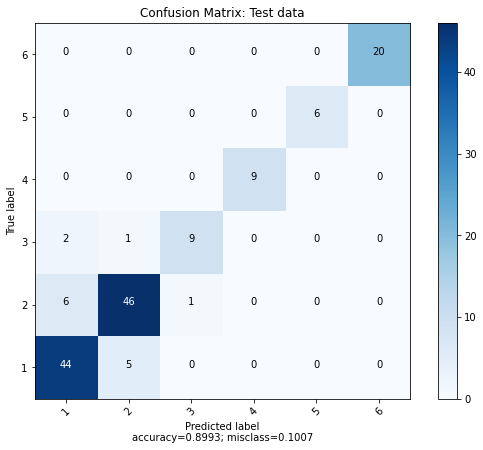

In [85]:
print('\n','#'*10,'Result for {} Data'.format('Test'), '#'*10, '\n')

y_pred = model.predict(X_std_np, verbose=0 )
print('log_loss:   ', log_loss(one_hot_y, y_pred, eps=1e-15))

y_true = one_hot_y.argmax(axis=1)
y_pred = y_pred.argmax(axis=1)
print('accuracy:   ',(y_pred==y_true).mean(), '\n')

target_names = ['class {}'.format(i+1) for i in range(6)]
print(classification_report(y_true, y_pred, target_names=target_names))

confuTst = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm           = confuTst, 
                      normalize    = False,
                      target_names = ['1', '2', '3', '4', '5', '6'],
                      title        = "Confusion Matrix: Test data")

In [86]:
# Call the stats function to print out statistics for the training
#stats_class(X_std_np, one_hot_y, 'Training', model)

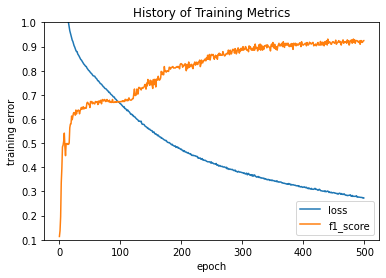

In [87]:
# Training history
plt.figure('Model training')
plt.ylabel('training error')
plt.xlabel('epoch')
for k in estimator_ex1.history.keys(): # plot the history of training metrics for each opoch
    plt.plot(estimator_ex1.history[k], label = k) 
plt.legend(loc='best')
plt.title('History of Training Metrics')
plt.ylim(0.1,1)
plt.show()
#plt.savefig('../Vis/NN_pre-made_training_history.png')

https://chrisalbon.com/code/deep_learning/keras/k-fold_cross-validating_neural_networks/

# K-Fold Cross Validation

https://www.machinecurve.com/index.php/2020/02/18/how-to-use-k-fold-cross-validation-with-keras/

In [88]:
num_folds = 4
# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
acc_per_fold = []
loss_per_fold = []
for train, test in kfold.split(X_std, one_hot_y):
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history = model.fit(X_std_np[train], one_hot_y[train],
        #batch_size=batch_size,
        epochs=10,
        verbose=0)
    # Generate generalization metrics
    scores = model.evaluate(X_std_np[test], one_hot_y[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 0.3239695131778717; f1_score of 90.19075036048889%
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 0.29354947805404663; f1_score of 79.43528294563293%
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 0.35831892490386963; f1_score of 67.38095283508301%
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 0.3674943745136261; f1_score of 86.57088279724121%


In [89]:
sum(acc_per_fold)/len(acc_per_fold)

80.89446723461151

In [90]:
sum(loss_per_fold)/len(loss_per_fold)

0.3358330726623535

# Random Search